In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import itertools
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# 1. Carregar e preparar a base
# -------------------------------
df = pd.read_excel("Base.xlsx")
df['Data'] = pd.to_datetime(df['Data'])
df.set_index('Data', inplace=True)
serie = df['Acidentes'].asfreq('D').dropna()

# -------------------------------
# 2. Decomposição da série temporal
# -------------------------------
result = seasonal_decompose(serie, model='additive', period=7)
result.plot()
plt.suptitle("Decomposição da Série Temporal (Acidentes)", y=1.02)
plt.show()

# -------------------------------
# 3. Teste de estacionariedade (ADF)
# -------------------------------
adf_result = adfuller(serie)
print("Estatística ADF:", adf_result[0])
print("Valor-p:", adf_result[1])
print("Valores Críticos:", adf_result[4])

# -------------------------------
# 4. Gráficos ACF e PACF
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(serie, ax=axes[0], lags=40)
axes[0].set_title("Função de Autocorrelação (ACF)")
plot_pacf(serie, ax=axes[1], lags=40, method='ywm')
axes[1].set_title("Função de Autocorrelação Parcial (PACF)")
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Validação cruzada SARIMA (p,d,q)(P,D,Q,S)
# -------------------------------
p = d = q = range(0, 2)  # valores até 1 para ARIMA
P = D = Q = range(0, 2)  # valores até 1 para sazonal
S = 7 # período sazonal (diário)

pdq_combinations = list(itertools.product(p, d, q))
seasonal_pdq_combinations = list(itertools.product(P, D, Q, [S]))

results = []
for param in pdq_combinations:
    for param_seasonal in seasonal_pdq_combinations:
        try:
            model = SARIMAX(serie,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            fit = model.fit(disp=False)
            fitted = fit.fittedvalues

            rmse = np.sqrt(mean_squared_error(serie, fitted))
            mae = mean_absolute_error(serie, fitted)
            mape = mean_absolute_percentage_error(serie, fitted)

            results.append([param, param_seasonal, fit.aic, fit.bic, rmse, mape, mae])
        except:
            continue

# Montar tabela de resultados
results_df = pd.DataFrame(results, columns=["(p,d,q)", "(P,D,Q,S)", "AIC", "BIC", "RMSE", "MAPE", "MAE"])
results_df = results_df.sort_values("AIC").reset_index(drop=True)

print("\nTabela de Validação Cruzada SARIMA:")
print(results_df.to_string(index=False, float_format="%.3f"))

KeyboardInterrupt: 

In [ ]:
!pip install prophet

Agora, vamos preparar os dados e rodar o modelo Prophet.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5y4ruqdu/iysn86w5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5y4ruqdu/58s17g7n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72670', 'data', 'file=/tmp/tmp5y4ruqdu/iysn86w5.json', 'init=/tmp/tmp5y4ruqdu/58s17g7n.json', 'output', 'file=/tmp/tmp5y4ruqdu/prophet_model9mc4mtjq/prophet_model-20250907152354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:23:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:23:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
756,2017-01-26,640.961944,521.212492,761.769803
757,2017-01-27,657.657490,540.877749,772.387617
758,2017-01-28,579.864990,460.556783,694.898869
759,2017-01-29,555.176688,436.435638,664.665506
760,2017-01-30,619.243174,497.153004,728.551384


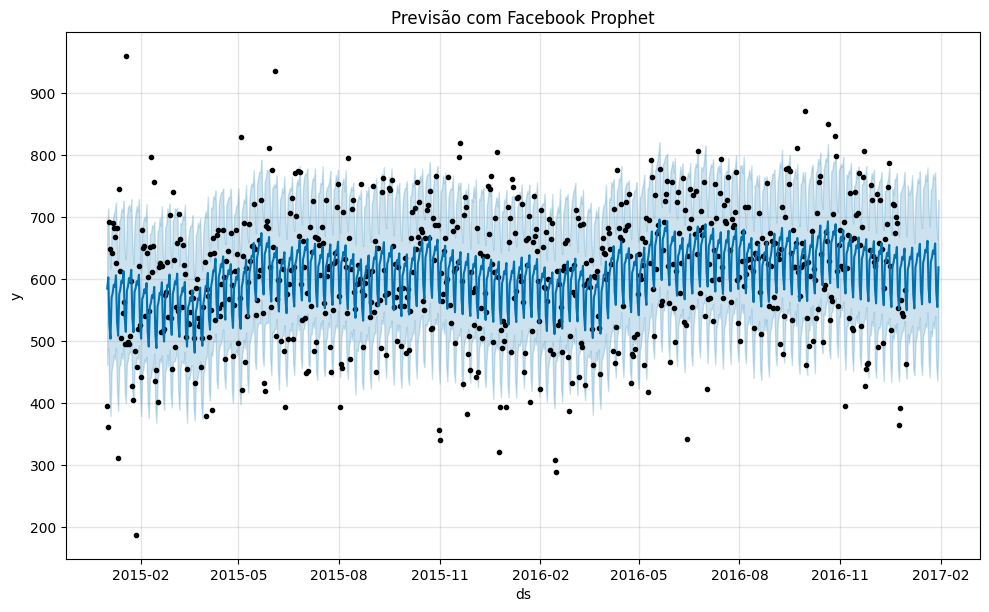

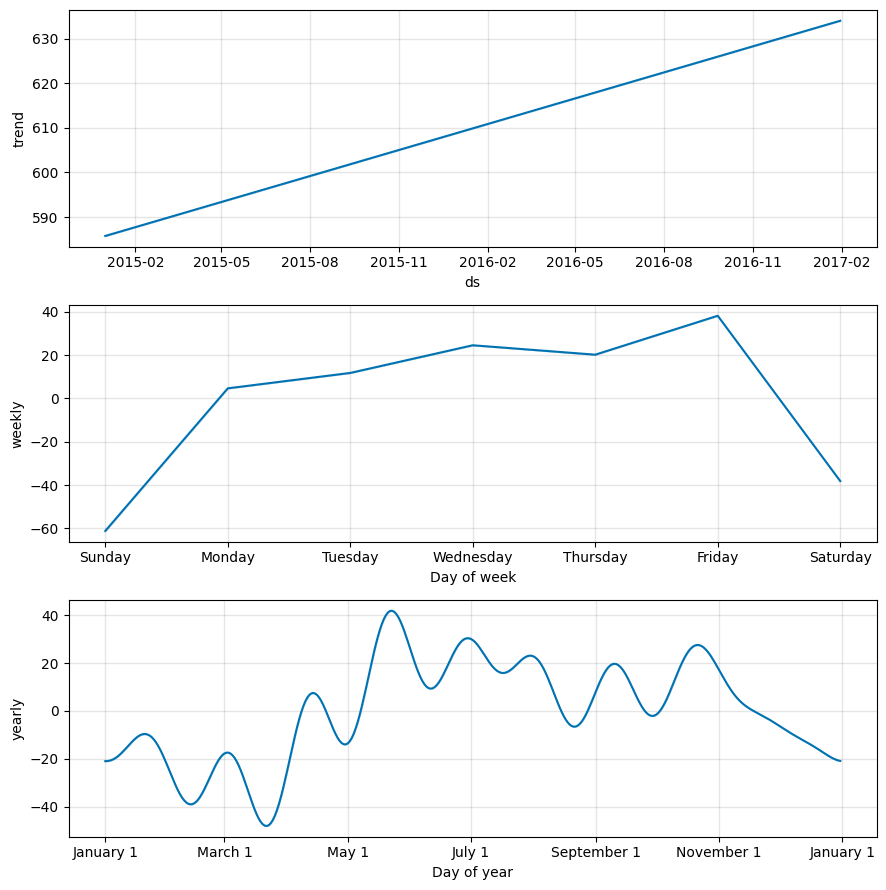

In [ ]:
from prophet import Prophet

# Preparar os dados no formato exigido pelo Prophet (ds, y)
prophet_df = serie.reset_index()
prophet_df.columns = ['ds', 'y']

# Inicializar e ajustar o modelo Prophet
model = Prophet()
model.fit(prophet_df)

# Criar dataframe para futuras previsões (por exemplo, 30 dias)
future = model.make_future_dataframe(periods=30)

# Fazer as previsões
forecast = model.predict(future)

# Exibir as previsões
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plotar os resultados
fig1 = model.plot(forecast)
plt.title("Previsão com Facebook Prophet")
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
# Salvar a tabela de validação cruzada ARIMA em um arquivo Excel
results_df.to_excel("Sarima_cross_validation_results.xlsx", index=False)

print("Tabela de validação cruzada ARIMA salva em 'arima_cross_validation_results.xlsx'")

Tabela de validação cruzada ARIMA salva em 'arima_cross_validation_results.xlsx'
